In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import swifter
import json
from collections import namedtuple
import re
import copy

import itertools
from pprint import pprint

# Functions

In [27]:
# Find files
# This function input the path of experiment directory and output a list of device directories of the experiment directory.
def find_device_under_exp(exp_dir_path):
    dev_dir_list = sorted([os.path.join(exp_dir_path, d) for d in os.listdir(exp_dir_path) if d.startswith('qc') or d.startswith('sm')])
    return dev_dir_list

def find_trace_under_device(dev_dir_path):
    trace_dir_list = sorted([os.path.join(dev_dir_path, d) for d in os.listdir(dev_dir_path)])
    return trace_dir_list


# Convenience instance
class EXPERIMENT():
    def __init__(self, exp_dir_path, settings):
        self.path = exp_dir_path
        self.settings = json.loads(settings)
    def __repr__(self):
        return f'EXP: {self.path} -> {self.settings}'

In [28]:
def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8)) 
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.end).total_seconds(), target, ho))

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }
    
    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        try: lte_pci, lte_earfcn
        except: 
            lte_pci = df["PCI"].iloc[i]
            lte_earfcn = int(df["Freq"].iloc[i])

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
        
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            _, idx = find_1st_after(i, 'ueCapabilityInformation',look_after=1)
            if idx is not None:
                sup_band = df['bandEUTRA'].iloc[idx]
                others += f' supported band: {sup_band}.' 

            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'({lte_pci}, {lte_earfcn}) -> ({serv_cell}, {serv_freq})'
            
            # Check if caused by RLF III.
            a, idx = find_1st_before(i, 'rrcConnectionReestablishmentReject', look_before=1)
            if a is not None:
                others += ' After RLF III.'

            D['Conn_Req'].append(HO(start=t,end=end,trans=trans, others=others))

            nr_pci = 'O'
            lte_pci = serv_cell
            lte_earfcn = serv_freq
            
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            lte_pci = target_cell
            lte_earfcn = target_freq

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        others += f' Near after RLF of trans: {ho.trans}.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

                lte_pci = serv_cell
                lte_earfcn = serv_freq

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans)) 

                # lte_pci, lte_earfcn will be updated in rrcConnectionRequest.     
                
            else:

                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    others += ' Result in gNB release.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Result in MN HO to eNB.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D


In [29]:
# Statistic functions
# This function input the file path of the loss_latency csv and output the loss and excessive latency rate.
def count_loss_excl_rate(file_path):

    df = pd.read_csv (file_path)

    # Total package in the experiment
    total_pkg_num = len(df)

    # Loss calculate
    loss_cond = df['lost'] == True
    try: loss_num = loss_cond.value_counts().loc[True]
    except: loss_num = 0
    loss_rate = loss_num/total_pkg_num

    # Excexxive latency calculate
    exc_lat = 0.1
    excl_cond = df[loss_cond==False]['latency'] > exc_lat
    try: excl_num = excl_cond.value_counts().loc[True]
    except: excl_num = 0
    excl_rate = excl_num/total_pkg_num

    return loss_rate, excl_rate

# This function input two file paths of the loss_latency csv and output the 
# loss and excessive latency rate of dual radio condition.
def count_loss_excl_rate_dual(file_path1, file_path2):

    df1 = pd.read_csv(file_path1)
    df2 = pd.read_csv(file_path2)

    start_seq = df1['seq'].iloc[0] if df1['seq'].iloc[0] >=  df2['seq'].iloc[0] else df2['seq'].iloc[0]
    end_seq = df1['seq'].iloc[-1] if df1['seq'].iloc[-1] <=  df2['seq'].iloc[-1] else df2['seq'].iloc[-1]
    total_pkg_num = end_seq - start_seq + 1

    cond1 = (df1['seq'] >= start_seq) & (df1['seq'] <= end_seq)
    df1 = df1[cond1]
    df1 = df1.reset_index(drop=True)
    cond2 = (df2['seq'] >= start_seq) & (df2['seq'] <= end_seq)
    df2 = df2[cond2]
    df2 = df2.reset_index(drop=True)

    # Loss calculate for dual radios redundant packets.
    loss_cond = (df1['lost'] == True) & (df2['lost'] == True)
    try: loss_num = loss_cond.value_counts().loc[True]
    except: loss_num = 0
    loss_rate = loss_num/total_pkg_num

    # Excexxive latency calculate for dual radios redundant packets.
    exc_lat = 0.1   
    excl_cond1 = df1[(loss_cond==False)]['latency'] > exc_lat
    excl_cond2 = df2[(loss_cond==False)]['latency'] > exc_lat
    excl_cond = (excl_cond1 == True) & (excl_cond2 == True)
    try: excl_num = excl_cond.value_counts().loc[True]
    except: excl_num = 0
    excl_rate = excl_num/total_pkg_num

    return loss_rate, excl_rate

# This function input two file paths of the loss_latency csv and output the 
# loss and excessive latency rate of dual radio condition.
def count_loss_excl_rate_dual(file_path1, file_path2):

    df1 = pd.read_csv(file_path1)
    df2 = pd.read_csv(file_path2)

    start_seq = df1['seq'].iloc[0] if df1['seq'].iloc[0] >=  df2['seq'].iloc[0] else df2['seq'].iloc[0]
    end_seq = df1['seq'].iloc[-1] if df1['seq'].iloc[-1] <=  df2['seq'].iloc[-1] else df2['seq'].iloc[-1]
    total_pkg_num = end_seq - start_seq + 1

    cond1 = (df1['seq'] >= start_seq) & (df1['seq'] <= end_seq)
    df1 = df1[cond1]
    df1 = df1.reset_index(drop=True)
    cond2 = (df2['seq'] >= start_seq) & (df2['seq'] <= end_seq)
    df2 = df2[cond2]
    df2 = df2.reset_index(drop=True)

    # Loss calculate for dual radios redundant packets.
    loss_cond = (df1['lost'] == True) & (df2['lost'] == True)
    try: loss_num = loss_cond.value_counts().loc[True]
    except: loss_num = 0
    loss_rate = loss_num/total_pkg_num

    # Excexxive latency calculate for dual radios redundant packets.
    exc_lat = 0.1   
    excl_cond1 = df1[(loss_cond==False)]['latency'] > exc_lat
    excl_cond2 = df2[(loss_cond==False)]['latency'] > exc_lat
    excl_cond = (excl_cond1 == True) & (excl_cond2 == True)
    try: excl_num = excl_cond.value_counts().loc[True]
    except: excl_num = 0
    excl_rate = excl_num/total_pkg_num

    return loss_rate, excl_rate

# Loss/Excl Lat  Check

## Single Radio

In [42]:
# This place give a XXXX-XX-XX.md file and find the experiment directory path
# and the corresponding band settings. It will be presented by a list of special
# instance EXPERIMENTs.
md_files = ['/home/wmnlab/D/database/2023-08-29/2023-08-29.md', 
            '/home/wmnlab/D/database/2023-09-12_1/2023-09-12.md',
            '/home/wmnlab/D/database/2023-09-22/2023-09-22.md']
EXPs = []

for md_file_path in md_files:

    date_dir_path = os.path.dirname(md_file_path)

    with open(md_file_path) as f:

        exp = f.readline()[:-1]
        settings = f.readline()[:-1]

        while exp != '#endif' and settings:
            E = EXPERIMENT(os.path.join(date_dir_path, exp), settings)
            EXPs.append(E)
            exp = f.readline()[:-1]
            settings = f.readline()[:-1]

pprint(EXPs)

[EXP: /home/wmnlab/D/database/2023-08-29/Modem_Action_Test -> {'qc00': 'test', 'qc03': 'test'},
 EXP: /home/wmnlab/D/database/2023-08-29/Modem_Control_Group -> {'qc00': 'All', 'qc03': 'All'},
 EXP: /home/wmnlab/D/database/2023-09-12_1/Modem_Action_Test -> {'qc00': 'test', 'qc03': 'test'},
 EXP: /home/wmnlab/D/database/2023-09-12_1/Modem_Control_Group -> {'qc00': 'All', 'qc03': 'All'},
 EXP: /home/wmnlab/D/database/2023-09-22/Modem_Control_Group2 -> {'qc00': 'All', 'qc03': 'LTE'}]


In [6]:
# Here is the example of given a experiment directory and plot the 
# box plot of DL/UL loss/excessive latency. 

# Still need to revise here.

dev_metric_dicts = []

for EXP in EXPs:

    dev_metric_dict = {}    
    exp_dir_path = EXP.path
    settings = EXP.settings 

    dev_dir_list = find_device_under_exp(exp_dir_path)

    for dev_dir_path in dev_dir_list:

        dev = dev_dir_path.split('/')[-1]
        metrics_dict = {}
        trace_dir_list = find_trace_under_device(dev_dir_path)
        dl_loss_rates, dl_excl_rates = [], []    
        ul_loss_rates, ul_excl_rates = [], []

        for trace_dir_path in trace_dir_list:

            # if '#01' not in trace_dir_path:
            #     continue

            dl_file_path = os.path.join(trace_dir_path, 'data/udp_dnlk_loss_latency.csv')
            ul_file_path = os.path.join(trace_dir_path, 'data/udp_uplk_loss_latency.csv')

            dl_loss_rate, dl_excl_rate = count_loss_excl_rate(dl_file_path)
            ul_loss_rate, ul_excl_rate = count_loss_excl_rate(ul_file_path)

            dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate)
            ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate)
        
        metrics_dict['dl_loss'] = dl_loss_rates
        metrics_dict['dl_excl'] = dl_excl_rates
        metrics_dict['ul_loss'] = ul_loss_rates
        metrics_dict['ul_excl'] = ul_excl_rates

        dev_metric_dict[dev + ' ' + settings[dev]] = metrics_dict

    dev_metric_dicts.append(dev_metric_dict)

In [7]:
import copy


settings = ['qc00 test', 'qc03 test', 'qc00 All', 'qc03 All']
empty_dict = {'dl_loss': [],'dl_excl': [],'ul_loss': [], 'ul_excl': []}
all_dev_metric_dict = {k: copy.deepcopy(empty_dict) for k in ['qc00 test', 'qc03 test', 'qc00 All', 'qc03 All']}

for d in dev_metric_dicts:
    for device in d:
        for metric in d[device]:
            all_dev_metric_dict[device][metric] += d[device][metric]

In [9]:
# all_dev_metric_dict

In [ ]:
# dev_metric_dicts

In [10]:
settings

['qc00 test', 'qc03 test', 'qc00 All', 'qc03 All']

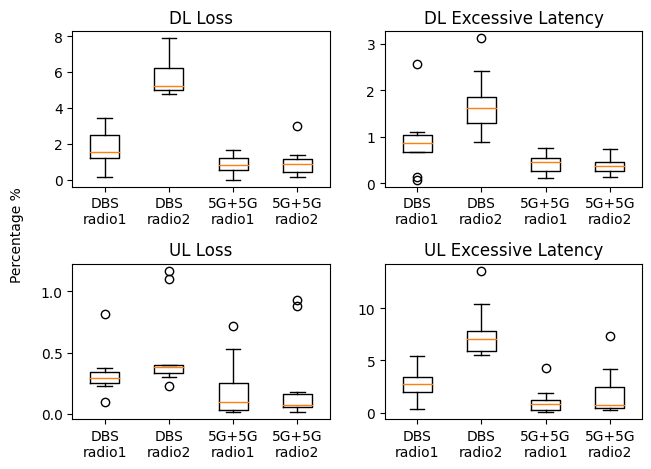

In [11]:
labels = [ 'DBS\nradio1', 'DBS\nradio2', '5G+5G\nradio1', '5G+5G\nradio2']
dl_loss_boxes, dl_excl_boxes = [], []
ul_loss_boxes, ul_excl_boxes = [], []

fig, axes = plt.subplots(2,2)

# i = 0
# for d in dev_metric_dicts:
    
#     for k, v in d.items():

#         dl_loss_box = [value*100 for value in d[k]['dl_loss'] ] 
#         dl_excl_box = [value*100 for value in d[k]['dl_excl'] ] 
#         ul_loss_box = [value*100 for value in d[k]['ul_loss'] ]
#         ul_excl_box = [value*100 for value in d[k]['ul_excl'] ]

#         dl_loss_boxes.append(dl_loss_box)
#         dl_excl_boxes.append(dl_excl_box)
#         ul_loss_boxes.append(ul_loss_box)
#         ul_excl_boxes.append(ul_excl_box)
        
#         i += 1

for k, v in all_dev_metric_dict.items():

    dl_loss_box = [value*100 for value in all_dev_metric_dict[k]['dl_loss'] ] 
    dl_excl_box = [value*100 for value in all_dev_metric_dict[k]['dl_excl'] ] 
    ul_loss_box = [value*100 for value in all_dev_metric_dict[k]['ul_loss'] ]
    ul_excl_box = [value*100 for value in all_dev_metric_dict[k]['ul_excl'] ]

    dl_loss_boxes.append(dl_loss_box)
    dl_excl_boxes.append(dl_excl_box)
    ul_loss_boxes.append(ul_loss_box)
    ul_excl_boxes.append(ul_excl_box)


axes[0][0].boxplot(dl_loss_boxes, labels=labels)
axes[0][0].set_title('DL Loss')
axes[0][1].boxplot(dl_excl_boxes, labels=labels)
axes[0][1].set_title('DL Excessive Latency')
axes[1][0].boxplot(ul_loss_boxes, labels=labels)
axes[1][0].set_title('UL Loss')
axes[1][1].boxplot(ul_excl_boxes, labels=labels)
axes[1][1].set_title('UL Excessive Latency')

fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
# # Change Here
# num = 0
# dev_metric_dict = dev_metric_dicts[num]
# settings = EXPs[num].settings


# fig, axes = plt.subplots(2,2)
# dl_loss_boxes, dl_excl_boxes = [], []
# ul_loss_boxes, ul_excl_boxes = [], []
# labels = [settings[k] for k in list(dev_metric_dict.keys())]

# for k, v in dev_metric_dict.items():

#     dl_loss_box = [value*100 for value in dev_metric_dict[k]['dl_loss'] ] 
#     dl_excl_box = [value*100 for value in dev_metric_dict[k]['dl_excl'] ] 
#     ul_loss_box = [value*100 for value in dev_metric_dict[k]['ul_loss'] ]
#     ul_excl_box = [value*100 for value in dev_metric_dict[k]['ul_excl'] ]

#     dl_loss_boxes.append(dl_loss_box)
#     dl_excl_boxes.append(dl_excl_box)
#     ul_loss_boxes.append(ul_loss_box)
#     ul_excl_boxes.append(ul_excl_box)

# axes[0][0].boxplot(dl_loss_boxes, labels=labels)
# axes[0][0].set_title('DL Loss')
# axes[0][1].boxplot(dl_excl_boxes, labels=labels)
# axes[0][1].set_title('DL Excessive Latency')
# axes[1][0].boxplot(ul_loss_boxes, labels=labels)
# axes[1][0].set_title('UL Loss')
# axes[1][1].boxplot(ul_excl_boxes, labels=labels)
# axes[1][1].set_title('UL Excessive Latency')

# # fig.text(0.5, 0.0, 'common xlabel', ha='center', va='center', fontsize=16)
# fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical')

# plt.tight_layout()
# plt.show()

## Dual Radio Analysis

In [45]:
# This place calculate the dual redio performance 
# given a experiment directory.

# Still need to revise here.

comb_metric_dicts = []
corresponding_list = []

for EXP in EXPs:

    exp_dir_path = EXP.path
    settings = EXP.settings 

    dev_dir_list = find_device_under_exp(exp_dir_path)
    comb = itertools.combinations(dev_dir_list, 2)

    date = exp_dir_path.split('/')[-2]
    name = exp_dir_path.split('/')[-1]
    
    for dev_dir_path1, dev_dir_path2 in comb:
        
        dev1 = dev_dir_path1.split('/')[-1]
        dev2 = dev_dir_path2.split('/')[-1]

        trace_dir_list1 = find_trace_under_device(dev_dir_path1)
        trace_dir_list2 = find_trace_under_device(dev_dir_path2)
        
        for trace_dir_path1, trace_dir_path2 in zip(trace_dir_list1, trace_dir_list2):
            
            # Record
            trace = trace_dir_path1.split('/')[-1]
            print(date, name, dev1, dev2, trace)
            corresponding_list.append((date, name, dev1, dev2, trace))
            
            dl_file_path1 = os.path.join(trace_dir_path1, 'data/udp_dnlk_loss_latency.csv')
            ul_file_path1 = os.path.join(trace_dir_path1, 'data/udp_uplk_loss_latency.csv')
            dl_file_path2 = os.path.join(trace_dir_path2, 'data/udp_dnlk_loss_latency.csv')
            ul_file_path2 = os.path.join(trace_dir_path2, 'data/udp_uplk_loss_latency.csv')

            dl_loss_rate, dl_excl_rate = count_loss_excl_rate_dual(dl_file_path1, dl_file_path2)
            ul_loss_rate, ul_excl_rate = count_loss_excl_rate_dual(ul_file_path1, ul_file_path2)

            metrics_dict = {}
            metrics_dict['dl_loss'] = dl_loss_rate
            metrics_dict['dl_excl'] = dl_excl_rate
            metrics_dict['ul_loss'] = ul_loss_rate
            metrics_dict['ul_excl'] = ul_excl_rate

            comb_metric_dicts.append(metrics_dict)

2023-08-29 Modem_Action_Test qc00 qc03 #01
2023-08-29 Modem_Action_Test qc00 qc03 #02
2023-08-29 Modem_Action_Test qc00 qc03 #03
2023-08-29 Modem_Action_Test qc00 qc03 #04
2023-08-29 Modem_Control_Group qc00 qc03 #01
2023-08-29 Modem_Control_Group qc00 qc03 #02
2023-08-29 Modem_Control_Group qc00 qc03 #03
2023-08-29 Modem_Control_Group qc00 qc03 #04
2023-08-29 Modem_Control_Group qc00 qc03 #05
2023-08-29 Modem_Control_Group qc00 qc03 #06
2023-09-12_1 Modem_Action_Test qc00 qc03 #01
2023-09-12_1 Modem_Action_Test qc00 qc03 #02
2023-09-12_1 Modem_Action_Test qc00 qc03 #03
2023-09-12_1 Modem_Action_Test qc00 qc03 #04
2023-09-12_1 Modem_Action_Test qc00 qc03 #05
2023-09-12_1 Modem_Control_Group qc00 qc03 #01
2023-09-12_1 Modem_Control_Group qc00 qc03 #02
2023-09-12_1 Modem_Control_Group qc00 qc03 #03
2023-09-12_1 Modem_Control_Group qc00 qc03 #04
2023-09-22 Modem_Control_Group2 qc00 qc03 #01
2023-09-22 Modem_Control_Group2 qc00 qc03 #02
2023-09-22 Modem_Control_Group2 qc00 qc03 #03
2023-09

In [52]:
# comb_metric_dicts[0]

In [55]:
# corresponding_list[0]

In [48]:
action_group = {}
control_group = {} # All + All
control_group2 = {} # All + LTE

keys = ['dl_loss', 'dl_excl', 'ul_loss', 'ul_excl']

for k in keys:
    action_group[k] = []
    control_group[k] = []
    control_group2[k] = []

for comb_metric_dict, info in zip(comb_metric_dicts, corresponding_list):

    name = info[1]
    
    for k, v in comb_metric_dict.items():

        if name == 'Modem_Action_Test':
            action_group[k].append(v)
        elif name == 'Modem_Control_Group':
            control_group[k].append(v)
        elif name == 'Modem_Control_Group2':
            control_group2[k].append(v)
        

In [60]:
control_group2

{'dl_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.008125465706276834],
 'dl_excl': [0.0,
  0.0,
  0.00012755102040816328,
  0.0,
  0.0012700798983936081,
  0.00018450839158357874],
 'ul_loss': [0.0, 0.0, 0.0, 0.0, 1.2959998963200083e-05, 0.0],
 'ul_excl': [0.0,
  1.3813394848985061e-05,
  6.713211600429646e-06,
  1.3835947174353688e-05,
  1.2959998963200083e-05,
  0.0025689245289713656]}

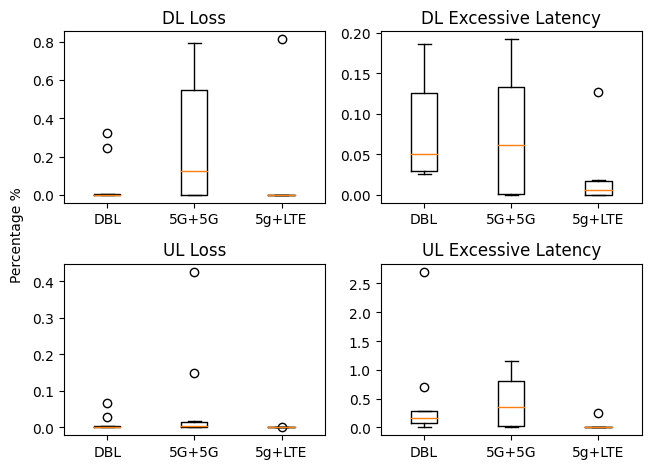

In [57]:
# Box plot of performance.

fig, axes = plt.subplots(2,2)
dl_loss_boxes, dl_excl_boxes = [], []
ul_loss_boxes, ul_excl_boxes = [], []
labels = ['DBL', '5G+5G', '5g+LTE']

for d in [action_group, control_group, control_group2]:

    dl_loss_box = [value*100 for value in d['dl_loss'] ] 
    dl_excl_box = [value*100 for value in d['dl_excl'] ] 
    ul_loss_box = [value*100 for value in d['ul_loss'] ]
    ul_excl_box = [value*100 for value in d['ul_excl'] ]

    dl_loss_boxes.append(dl_loss_box)
    dl_excl_boxes.append(dl_excl_box)
    ul_loss_boxes.append(ul_loss_box)
    ul_excl_boxes.append(ul_excl_box)


axes[0][0].boxplot(dl_loss_boxes, labels=labels)
axes[0][0].set_title('DL Loss')
axes[0][1].boxplot(dl_excl_boxes, labels=labels)
axes[0][1].set_title('DL Excessive Latency')
axes[1][0].boxplot(ul_loss_boxes, labels=labels)
axes[1][0].set_title('UL Loss')
axes[1][1].boxplot(ul_excl_boxes, labels=labels)
axes[1][1].set_title('UL Excessive Latency')

# fig.text(0.5, 0.0, 'common xlabel', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

In [58]:
# comb_metric_dicts

In [59]:
empty_dict = {'dl_loss': [],'dl_excl': [],'ul_loss': [], 'ul_excl': []}
all_comb_metric_dict = {k: copy.deepcopy(empty_dict) for k in comb_metric_dicts[0].keys()}

for d in comb_metric_dicts:
    for device in d:
        for metric in d[device]:
            all_comb_metric_dict[device][metric] += d[device][metric]
            
# all_comb_metric_dict

TypeError: 'numpy.float64' object is not iterable

In [22]:
# This place calculate the average performance of an 
# experiment setting and plot the heatmap below.
 
num = 0
comb_metric_dict = comb_metric_dicts[num]
settings = EXPs[num].settings

# num_of_devs = 2
num_of_devs = len(settings)
data_dl_loss = np.zeros((num_of_devs, num_of_devs))
data_dl_excl = np.zeros((num_of_devs, num_of_devs))
data_ul_loss = np.zeros((num_of_devs, num_of_devs))
data_ul_excl = np.zeros((num_of_devs, num_of_devs))

keys = list(comb_metric_dict.keys())
count = 0

for i in range(num_of_devs):
    for j in range(i+1, num_of_devs):

        k = keys[count]
        
        dl_loss = np.mean(comb_metric_dict[k]['dl_loss'])
        dl_excl = np.mean(comb_metric_dict[k]['dl_excl'])
        ul_loss = np.mean(comb_metric_dict[k]['ul_loss'])
        ul_excl = np.mean(comb_metric_dict[k]['ul_excl'])

        data_dl_loss[i, j] = dl_loss*100
        data_dl_excl[i, j] = dl_excl*100
        data_ul_loss[i, j] = ul_loss*100
        data_ul_excl[i, j] = ul_excl*100

        count += 1


In [ ]:
fig, axes = plt.subplots(2,2, figsize=(8,6))

# labels = ['378', '3']
labels = list(settings.values())
mask = np.tri(data_dl_loss.shape[0], dtype=bool, k=0)

sns.heatmap(data_dl_loss, ax=axes[0,0], mask=mask, annot=True, fmt=".2f")
axes[0,0].set_xticklabels(labels, rotation=90)
axes[0,0].set_yticklabels(labels, rotation=0)
axes[0,0].set_title('DL Loss')
sns.heatmap(data_dl_excl, ax=axes[0,1], mask=mask, annot=True, fmt=".2f")
axes[0,1].set_xticklabels(labels, rotation=90)
axes[0,1].set_yticklabels(labels, rotation=0)
axes[0,1].set_title('DL Excessive Latency')
sns.heatmap(data_ul_loss, ax=axes[1,0], mask=mask, annot=True, fmt=".2f")
axes[1,0].set_xticklabels(labels, rotation=90)
axes[1,0].set_yticklabels(labels, rotation=0)
axes[1,0].set_title('UL Loss')
sns.heatmap(data_ul_excl, ax=axes[1,1], mask=mask, annot=True, fmt=".2f")
axes[1,1].set_xticklabels(labels, rotation=90)
axes[1,1].set_yticklabels(labels, rotation=0)
axes[1,1].set_title('UL Excessive Latency')

plt.tight_layout()
plt.show()

dl_loss, dl_excl, ul_loss, ul_excl <br>
0.00, 0.07, 0.02, 0.82 -- Modem action <br>
0.33, 0.08, 0.10, 0.46 -- Modem Control 

# HO analysis

In [ ]:
rrc_files = []

for EXP in EXPs:

    dev_metric_dict = {}    
    exp_dir_path = EXP.path
    settings = EXP.settings 

    dev_dir_list = find_device_under_exp(exp_dir_path)

    record_dict = {k: [] for k in settings.keys()}

    for dev_dir_path in dev_dir_list:

        dev = dev_dir_path.split('/')[-1]

        trace_dir_list = find_trace_under_device(dev_dir_path)
        
        for trace_dir_path in trace_dir_list:

            rrc_file_path = os.path.join(trace_dir_path, 'data')
            rrc_file = [os.path.join(rrc_file_path, s) for s in os.listdir(rrc_file_path) if s.endswith('_rrc.csv')][0]
            
            record_dict[dev].append(rrc_file)


    rrc_files.append(record_dict)

pprint(EXPs)

In [ ]:
rrc_files

In [ ]:
types = ['Conn_Req', 'LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel', 'SN_HO', 'RLF_II', 'RLF_III', 'SCG_RLF']
total1 = {type: 0 for type in types} # Test Radio1
total2 = {type: 0 for type in types} # Test Radio2
total3 = {type: 0 for type in types} # 5G Radio1
total4 = {type: 0 for type in types} # 5G Radio2

for rrc_file in rrc_files:

    f1s = rrc_file['qc00']
    f2s = rrc_file['qc03']

    for i, (f1, f2) in enumerate(zip(f1s, f2s)):

        hos1 = parse_mi_ho(f1)
        t1 = {k:len(v) for k, v in hos1.items()}
        
        print(f1, t1)

        for type in types:
            if 'Modem_Action_Test' in f1:
                total1[type] += t1[type]
            elif 'Modem_Control_Group' in f1:
                total3[type] += t1[type]

        hos2 = parse_mi_ho(f2)
        t2 = {k:len(v) for k, v in hos2.items()}
        for type in types:
            if 'Modem_Action_Test' in f2:
                total2[type] += t2[type]
            elif 'Modem_Control_Group' in f2:
                total4[type] += t2[type]

        print(f2, t2)

In [ ]:
n1, n2 = 9, 10
total1 = {k:round(v/n1, 2) for k, v in total1.items()}
total2 = {k:round(v/n1, 2) for k, v in total2.items()}
total3 = {k:round(v/n2, 2) for k, v in total3.items()}
total4 = {k:round(v/n2, 2) for k, v in total4.items()}
total1, total2, total3, total4

In [ ]:
record_dict = rrc_files[1]
keys = list(record_dict.keys())
values = list(record_dict.values())

dev1, rrc_file_list1 = keys[0], values[0]
dev2, rrc_file_list2 = keys[1], values[1]

for file1, file2 in zip(rrc_file_list1, rrc_file_list2):

    HOs1 = parse_mi_ho(file1)
    ordered_HOs1 = print_trans(HOs1, p=False)
    HOs2 = parse_mi_ho(file2)
    ordered_HOs2 = print_trans(HOs2, p=False)


In [ ]:
L = []

for ho in ordered_HOs1:

    
    write_list = [ho[1].start, ho[0], ho[1].trans, ho[1].others, 1]
    L.append(write_list)
    write_list = [str(s) for s in write_list]

for ho in ordered_HOs2:

    write_list = [ho[1].start, ho[0], ho[1].trans, ho[1].others, 2]
    L.append(write_list)
    write_list = [str(s) for s in write_list]


In [ ]:
save_path = '/home/wmnlab/sheng-ru/HO_compare.csv'

with open(save_path, 'w') as f:

    f.write('@'.join(['timestamp', 'type', 'trans', 'others', 'num']) + '\n')

    for l in sorted(L, key = lambda x: x[0]):

        write_list = l
        write_list = [str(s) for s in write_list]
        f.write('@'.join(write_list) + '\n')

In [ ]:
# # This place give a XXXX-XX-XX.md file and find the experiment directory path
# # and the corresponding band settings. It will be presented by a list of special
# # instance EXPERIMENTs.
# md_files = ['/home/wmnlab/D/database/2023-06-24/2023-06-24.md']
# EXPs = []

# for md_file_path in md_files:

#     date_dir_path = os.path.dirname(md_file_path)

#     with open(md_file_path) as f:

#         exp = f.readline()[:-1]
#         settings = f.readline()[:-1]

#         while exp != '#endif' and settings:
#             E = EXPERIMENT(os.path.join(date_dir_path, exp), settings)
#             EXPs.append(E)
#             exp = f.readline()[:-1]
#             settings = f.readline()[:-1]

# pprint(EXPs)

In [ ]:
# for EXP in EXPs:

#     exp_dir_path = EXP.path
#     settings = EXP.settings 

#     dev_dir_list = find_device_under_exp(exp_dir_path)

#     date = exp_dir_path.split('/')[-2]
#     name = exp_dir_path.split('/')[-1]
    

#     for dev_dir_path in dev_dir_list:    
    
#         dev = dev_dir_path.split('/')[-1]
        
#         trace_dir_list = find_trace_under_device(dev_dir_path)

#         for trace_dir_path in trace_dir_list:

#             trace = trace_dir_path1.split('/')[-1]

#             data_dir_path = os.path.join(trace_dir_path, 'data')
#             rrc_file = [p for p in os.listdir(data_dir_path) if p.endswith('_rrc.csv')][0]
#             rrc_file_path = os.path.join(data_dir_path, rrc_file)
            

#             print(rrc_file_path)
#             HOs = parse_mi_ho(rrc_file_path)
#             if len(HOs['RLF_III']) != 0:
#                 raise
            


In [ ]:
# HOs